In [2]:
import matplotlib.pyplot as plt
from IPython import display
import torch
from torch import nn
from torch.utils.data import DataLoader
from utils import load_mnist

ds_train, ds_valid = load_mnist('../dataset')

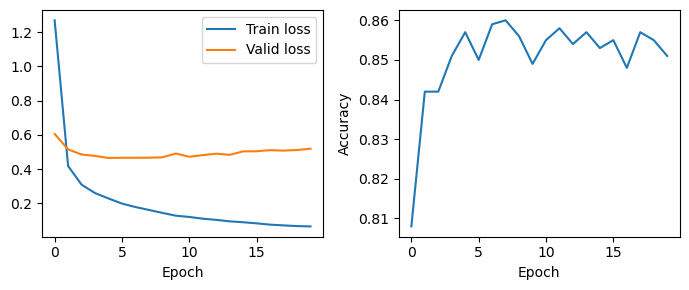

In [11]:
class Model(nn.Module):
    '''Modelo com uma camada linear.'''
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(28*28, 10)
        
    def forward(self, x):
        # Cada batch é um tensor de tamanho bsx1x28x28, redimensionamos para bsx768
        x = x.reshape(x.shape[0], -1)
        return self.layer(x)
    
def train_step(model, dl_train, optim, loss_func):
    '''Executa uma época de treinamento. Note que o termo `step` no nome
    da função não se refere a um passo de atualização de parâmetros, como
    estávamoss fazendo até o momento. Nesta função são feitas várias 
    atualizações, uma para cada batch.'''

    # Coloca o modelo em modo treinamento. Neste notebook não fará diferença,
    # mas algumas camadas (batchnorm, dropout) precisam disso
    model.train()
    # Armazenará a média das losses de todos os bathces
    loss_log = 0.
    for imgs, targets in dl_train:
        optim.zero_grad()
        scores = model(imgs)
        loss = loss_func(scores, targets)
        loss.backward()
        optim.step()
        
        # Multiplica por batch_size porque o último batch pode ter tamanho diferente
        loss_log += loss.detach()*imgs.shape[0]

    # Média das losses calculadas
    loss_log /= len(dl_train.dataset)

    return loss_log.item()

def accuracy(scores, targets):
    return (scores.argmax(dim=1)==targets).float().mean()

# Anotador para evitar que gradientes sejam registrados dentro da função
@torch.no_grad()
def valid_step(model, dl_valid, loss_func, perf_func):

    # Coloca o modelo em modo de validação. 
    model.eval()
    # Variáveis que armazenarão a loss e a acurácia
    loss_log = 0.
    perf_log = 0.
    for imgs, targets in dl_valid:
        scores = model(imgs)
        loss = loss_func(scores, targets)
        perf = perf_func(scores, targets)

        # Multiplica por batch_size porque o último batch pode ter tamanho diferente
        loss_log += loss*imgs.shape[0]
        perf_log += perf*imgs.shape[0]

    # Média dos valores calculados
    loss_log /= len(dl_valid.dataset)
    perf_log /= len(dl_valid.dataset)

    return loss_log.item(), perf_log.item()

def show_log(logger):

    epochs, losses_train, losses_valid, accs = zip(*logger)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))
    ax1.plot(epochs, losses_train, label='Train loss')
    ax1.plot(epochs, losses_valid, label='Valid loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax2.plot(epochs, accs)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    fig.tight_layout()

    display.clear_output(wait=True) 
    plt.show()

def train(model, ds_train, ds_valid, bs, num_epochs, lr, perf_func):

    dl_train = DataLoader(ds_train, batch_size=bs, shuffle=True)
    dl_valid = DataLoader(ds_valid, batch_size=bs, shuffle=False)

    loss_func = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    logger = []
    for epoch in range(0, num_epochs):
        loss_train = train_step(model, dl_train, optim, loss_func)
        loss_valid, perf = valid_step(model, dl_valid, loss_func, perf_func)
        logger.append((epoch, loss_train, loss_valid, perf))
        show_log(logger)
    
    return logger

model = Model()
logger = train(model, ds_train, ds_valid, bs=64, num_epochs=20, lr=0.1, perf_func=accuracy)

In [12]:
print(model.layer.weight.shape)

torch.Size([10, 784])


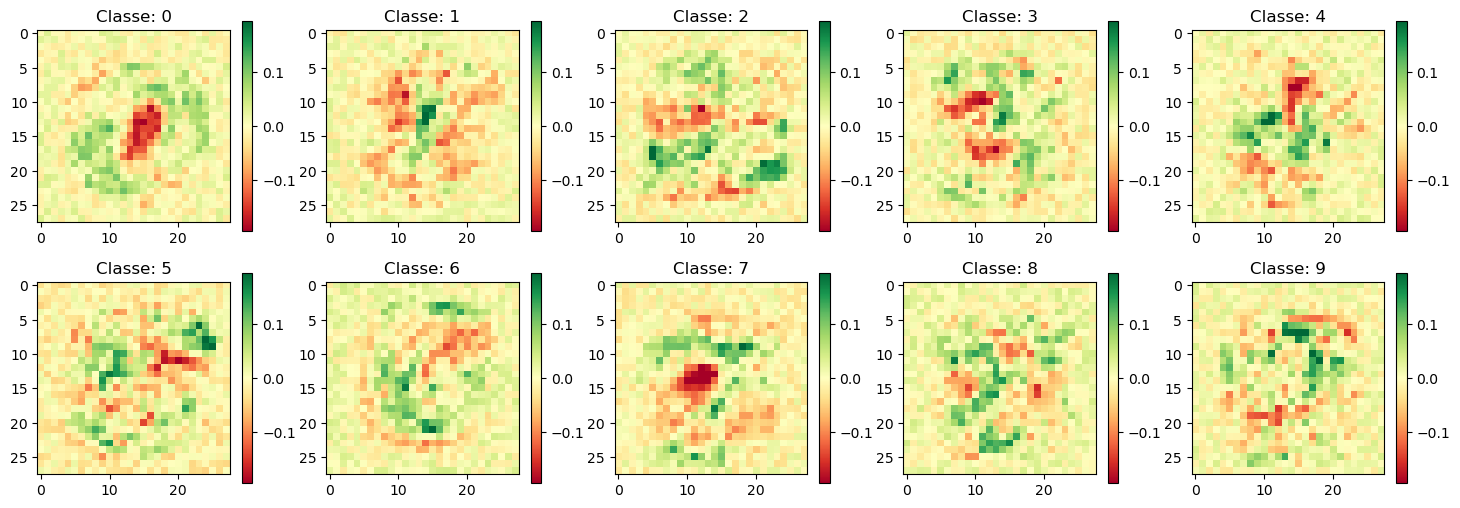

In [13]:
# Mapeia os valores de forma que o valor 0 seja o centro do mapa de cores
cn = plt.matplotlib.colors.CenteredNorm()

fig, axs = plt.subplots(2, 5, figsize=(18, 6))
axs = axs.reshape(-1)
for idx in range(10):
    # Redimensiona os pesos para uma imagem 28x28
    weight = model.layer.weight[idx].detach().reshape(28,28)
    ax = axs[idx]
    plot = ax.imshow(weight, 'RdYlGn', norm=cn)
    ax.set_title(f'Classe: {idx}')
    fig.colorbar(plot, ax=ax) 